In [1]:
# experiment tracker
sys.path.append('../../')
sys.path.append('../')
sys.path.append('../../experiment-impact-tracker/')

from experiment_impact_tracker.data_interface import DataInterface
from experiment_impact_tracker.data_utils import *
from experiment_impact_tracker.data_utils import (load_data_into_frame,
                                                  load_initial_info,
                                                  zip_data_and_info)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


### Notes
### local vs CC seem to huge FLOP difference during setup

loading region bounding boxes for computing carbon emissions region, this may take a moment...
 454/454... rate=442.62 Hz, eta=0:00:00, total=0:00:01, wall=22:17 EST
Done!


In [2]:
project_dir = '../'
fastsurfer_exp_dir = '{}/FastSurfer_experiments/'.format(project_dir)
preproc_exp_dir = '{}/preproc_pipeline_experiments/'.format(project_dir)
fastsurfer_results_dir = '{}results/exp_impact_tracker/'.format(fastsurfer_exp_dir)
preproc_results_dir = '{}results/exp_impact_tracker/'.format(preproc_exp_dir)
subject_lists = '{}subject_lists/ukb_pilot_subjects.csv'.format(project_dir)

In [52]:
def compute_aggregate_power(df, info, PUE, task_epoch_df):
    ''' this is similar to https://github.com/nikhil153/experiment-impact-tracker/blob/master/experiment_impact_tracker/utils.py, but partitioned according to different tasks in the pipeline (e.g. setup, predict, aggregate)'''

    # time calcs
    exp_end_timestamp = datetime.timestamp(info["experiment_end"])
    
    exp_len = exp_end_timestamp - datetime.timestamp(info["experiment_start"])
    exp_len_hours = exp_len / 3600.0
   
    time_differences = df["timestamp_orig"].diff()
    time_differences[0] = df["timestamp_orig"][0] - datetime.timestamp(
        info["experiment_start"]
    )

    # Add final timestamp and extrapolate last row of power estimates
    time_differences.loc[len(time_differences)] = (
        exp_end_timestamp - df["timestamp_orig"][len(df["timestamp_orig"]) - 1]
    )

    time_differences_in_hours = time_differences / 3600.0

    # rapl calcs
    power_draw_rapl_kw = df["rapl_estimated_attributable_power_draw"] / 1000.0
    power_draw_rapl_kw.loc[len(power_draw_rapl_kw)] = power_draw_rapl_kw.loc[
        len(power_draw_rapl_kw) - 1
    ]

    kw_hr_rapl = (
        np.multiply(time_differences_in_hours, power_draw_rapl_kw)
        if power_draw_rapl_kw is not None
        else None
    )

    # nvidia calcs
    has_gpu = False
    if "gpu_info" in info.keys():
        has_gpu = True
        num_gpus = len(info["gpu_info"])
        nvidia_power_draw_kw = df["nvidia_estimated_attributable_power_draw"] / 1000.0
        nvidia_power_draw_kw.loc[len(nvidia_power_draw_kw)] = nvidia_power_draw_kw.loc[
            len(nvidia_power_draw_kw) - 1
        ]

        # elementwise multiplication and sum
        kw_hr_nvidia = np.multiply(time_differences_in_hours, nvidia_power_draw_kw)

    

    if has_gpu and (kw_hr_rapl is not None):
        total_power_per_timestep = PUE * (kw_hr_nvidia + kw_hr_rapl)
    elif kw_hr_rapl is not None:
        total_power_per_timestep = PUE * (kw_hr_rapl)
    elif has_gpu:
        total_power_per_timestep = PUE * (kw_hr_nvidia)
    else:
        raise ValueError("Unable to get either GPU or CPU metric.")

    # Append last row which implies power draw from last sample extrapolated till the end of experiment
    df.loc[len(df)] = df.loc[len(df) - 1] ## Duplicating last row to match length of total_power_per_timestep
    df.loc[len(df)-1,'timestamp'] = task_epoch_df.loc[len(task_epoch_df)-1,'epoch_timestamp'] #update the timestamp to match end of experiment
    df['total_power_per_timestep'] = total_power_per_timestep.copy()

    task_power_df = pd.DataFrame(columns=['task','power'])
    if total_power_per_timestep is not None:
        task_power_df.loc[0] = ['Experiment', total_power_per_timestep.sum()]

        prev_epoch_power = 0
        print('number of timestamps: {}'.format(len(total_power_per_timestep)))
        
        for i in range(len(task_epoch_df)):
            task = task_epoch_df.loc[i,'task']
            epoch = task_epoch_df.loc[i,'epoch_timestamp']
            epoch_idx = len(df[df['timestamp'] <= epoch])
            current_epoch_power = total_power_per_timestep[:epoch_idx].sum()
            task_power_df.loc[i+1] = [task, current_epoch_power - prev_epoch_power ]
            prev_epoch_power = current_epoch_power

    return df, task_power_df


def get_tracker_data(experiment_name, logdir, use_cuda, read_flops):

    # Get total values from default data interface for the entire experiment
    info = load_initial_info(logdir)
    data_interface = DataInterface([logdir])
    total_power = data_interface.total_power
    total_carbon = data_interface.kg_carbon
    PUE = data_interface.PUE

    # Calculate your own sepeartely for each subtask in the experiment
    # impact tracker log
    tracker_df =  load_data_into_frame(logdir)

    if use_cuda:
        power_df = tracker_df[0][['timestamp','rapl_power_draw_absolute','rapl_estimated_attributable_power_draw','nvidia_draw_absolute','nvidia_estimated_attributable_power_draw']]
        power_df['total_attributable_power_draw'] = power_df['rapl_estimated_attributable_power_draw'] + power_df['nvidia_estimated_attributable_power_draw']

    else:
        power_df = tracker_df[0][['timestamp','rapl_power_draw_absolute','rapl_estimated_attributable_power_draw']]
        power_df['total_attributable_power_draw'] = power_df['rapl_estimated_attributable_power_draw']
        
    # start time from 0
    power_df['timestamp_orig'] = power_df['timestamp'].copy()
    power_df['timestamp'] = power_df['timestamp'] - power_df['timestamp'][0]
    power_df['experiment_name'] = experiment_name

    # papi log
    flops_df = None
    total_duration = 0
    if read_flops:
        compute_flops_csv = logdir + 'compute_costs_flop.csv'
        flops_df = pd.read_csv(compute_flops_csv)
        flops_df['experiment_name'] = experiment_name
    
        flops_df['start_time'] = flops_df['start_time'] - flops_df['start_time'][0]

        # Aggregate power draws per epoch for each papi context calculation (i.e. setup, axial, aggr etc))
        epoch_power_draw_list = []
        epoch_timestamps = list(flops_df['start_time'].values[1:]) + [flops_df['start_time'].values[-1] + flops_df['duration'].values[-1]]

        task_epoch_df = pd.DataFrame()
        task_epoch_df['task'] = flops_df['task']
        task_epoch_df['epoch_timestamp'] = epoch_timestamps
        
        power_df, task_power_df = compute_aggregate_power(power_df, info, PUE, task_epoch_df)
        flops_df = pd.merge(flops_df,task_power_df,on='task',how='left')

        print('total_power sanity check: default: {:6.5f}, calculated: {:6.5f}, {:6.5f}'.format(total_power, task_power_df.loc[0,'power'],power_df['total_power_per_timestep'].sum()))
    
    total_duration = (power_df['timestamp'].values[-1]-power_df['timestamp'].values[0])/3600

    tracker_summary_df = pd.DataFrame(columns=['experiment_name','total_power','total_carbon','PUE','total_duration'])
    tracker_summary_df.loc[0] = [experiment_name,total_power,total_carbon,PUE,total_duration]

    return power_df, flops_df, tracker_summary_df
 



### Custom set of expeirments

In [33]:
experiment_dict = {
                   'FastSurfer_local_cpu':('{}/track_sub_000_benchmark/'.format(fastsurfer_results_dir),False), 
                   'FastSurfer_CC_cpu':('{}/CC_cpu_test/'.format(fastsurfer_results_dir),False),
                   'FastSurfer_CC_gpu':('{}/CC_gpu_test/'.format(fastsurfer_results_dir),True),
                   'autorecon1_local_test_1':('{}/ReconAll_test_local_cpu/'.format(preproc_results_dir),False),
                   'autorecon2-3_local_test_1':('{}/ReconAll_test_location_override/'.format(preproc_results_dir),False),
                   'autorecon1_CC_test_1':('{}/ReconAll_test_CC_cpu/'.format(preproc_results_dir),False),
                   'autorecon1_CC_ukb_1':('{}/ReconAll_ukb_CC_cpu/'.format(preproc_results_dir),False)
                   }

read_flops = True

power_df_concat = pd.DataFrame()
flops_df_concat = pd.DataFrame()
tracker_summary_df_concat = pd.DataFrame()

for k,v in experiment_dict.items():
    power_df, flops_df, tracker_summary_df = get_tracker_data(k, v[0], v[1], read_flops)
    power_df_concat = power_df_concat.append(power_df)
    flops_df_concat = flops_df_concat.append(flops_df)
    tracker_summary_df_concat = tracker_summary_df_concat.append(tracker_summary_df)


number of timestamps: 2633
total_power sanity check: default: 0.067, calculated: 0.067
number of timestamps: 940
total_power sanity check: default: 0.135, calculated: 0.135
number of timestamps: 8
total_power sanity check: default: 0.002, calculated: 0.002
number of timestamps: 240
total_power sanity check: default: 0.004, calculated: 0.004
number of timestamps: 6808
total_power sanity check: default: 0.084, calculated: 0.084
number of timestamps: 332
total_power sanity check: default: 0.004, calculated: 0.004
number of timestamps: 239
total_power sanity check: default: 0.023, calculated: 0.023


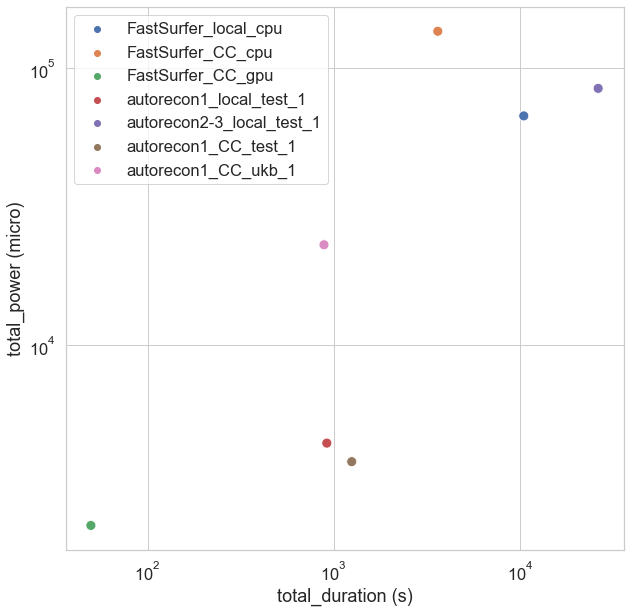

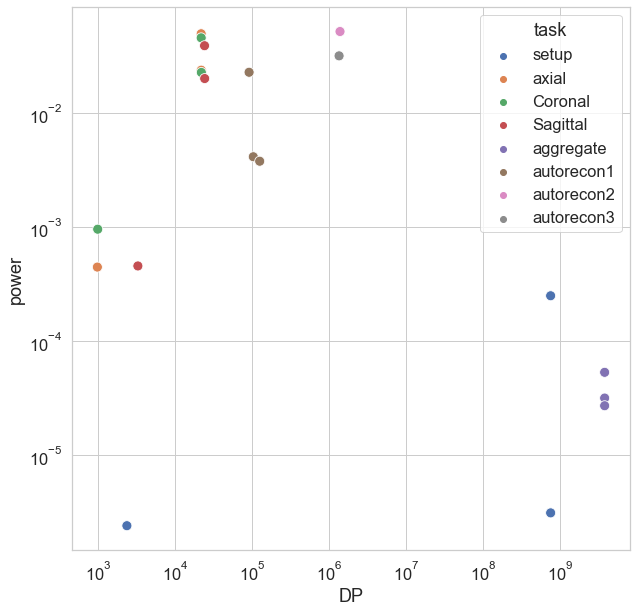

In [34]:
plot_df = tracker_summary_df_concat.copy()
plot_df['total_duration (s)'] = plot_df['total_duration'] * 3600
plot_df['total_power (micro)'] = plot_df['total_power'] * (10**6)
plot_df['avg_power (power/duration'] = plot_df['total_power'] * (10**6) / plot_df['total_duration'] * 3600

sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(figsize=(10,10),sharex=False,sharey=False)
    g = sns.scatterplot(y='total_power (micro)', x='total_duration (s)', hue='experiment_name', s=100, data=plot_df)
    g.set(xscale='log',yscale='log') 
    g.legend(loc=0)

plot_df = flops_df_concat.copy()

with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(figsize=(10,10),sharex=False,sharey=False)
    g = sns.scatterplot(y='power', x='DP', hue='task', s=100, data=plot_df)
    g.set(xscale='log',yscale='log') 

### UKB pilot experiment sets
- recon-all 
- fastsurfer
    - pruning_{0,25,50}
    - gpu/cpu

In [44]:
def collate_tracker_data(tracker_log_dir, exp_list, use_cuda, read_flops=True):
    experiment_dict = {}
    for id in exp_list:
        # reconall 
        tracker_path = tracker_log_dir + 'sub-{}/'.format(id)
        experiment_dict[id] = (tracker_path, use_cuda)

    power_df_concat = pd.DataFrame()
    flops_df_concat = pd.DataFrame()
    tracker_summary_df_concat = pd.DataFrame()
    i = 0
    for k,v in experiment_dict.items():
        print('{} subject_id: {}'.format(i, k))
        i += 1
        try:
            power_df, flops_df, tracker_summary_df = get_tracker_data(k, v[0], v[1], read_flops)
            power_df_concat = power_df_concat.append(power_df)
            flops_df_concat = flops_df_concat.append(flops_df)
            tracker_summary_df_concat = tracker_summary_df_concat.append(tracker_summary_df)
        except:
            continue

    return tracker_summary_df_concat, flops_df_concat, power_df_concat

In [53]:
save_perf = True

subject_df = pd.read_csv(subject_lists)
subject_ids = subject_df['eid']

ignore_subjects = {1009760}
subject_ids = list(set(subject_ids) - ignore_subjects)

print('Found {} subjects'.format(len(subject_ids)))

experiment_sets = {
                   'recon-all':(preproc_results_dir + 'ukb/', False), # log_dir, use_cuda
                #    'fastsurfer_gpu_prune_0':(fastsurfer_results_dir + 'ukb/gpu/', True) # log_dir, use_cuda
                  }

for exp_name, exp_config in experiment_sets.items(): 
    tracker_log_dir = exp_config[0]
    use_cuda = exp_config[1]
    tracker_summary_df_concat, flops_df_concat, power_df_concat = collate_tracker_data(tracker_log_dir, subject_ids, use_cuda)
    tracker_summary_df_concat['experiment_set'] = exp_name
    flops_df_concat['experiment_set'] = exp_name
    power_df_concat['experiment_set'] = exp_name
    
    if save_perf:
        tracker_summary_df_concat.to_csv('{}{}'.format(tracker_log_dir,'tracker_summary_df_concat.csv'))
        flops_df_concat.to_csv('{}{}'.format(tracker_log_dir,'flops_df_concat.csv'))
        power_df_concat.to_csv('{}{}'.format(tracker_log_dir,'power_df_concat.csv'))


Found 72 subjects
0 subject_id: 1047553
number of timestamps: 6
total_power sanity check: default: 0.00262, calculated: 0.00262, 0.00262
1 subject_id: 3553027
number of timestamps: 7
total_power sanity check: default: 0.00253, calculated: 0.00253, 0.00253
2 subject_id: 1406980
number of timestamps: 6
total_power sanity check: default: 0.00262, calculated: 0.00262, 0.00262
3 subject_id: 1013261
number of timestamps: 7
total_power sanity check: default: 0.00246, calculated: 0.00246, 0.00246
4 subject_id: 1037070
number of timestamps: 6
total_power sanity check: default: 0.00205, calculated: 0.00205, 0.00205
5 subject_id: 1554964
number of timestamps: 6
total_power sanity check: default: 0.00313, calculated: 0.00313, 0.00313
6 subject_id: 1027606
number of timestamps: 6
total_power sanity check: default: 0.00257, calculated: 0.00257, 0.00257
7 subject_id: 4451351
number of timestamps: 6
total_power sanity check: default: 0.00366, calculated: 0.00366, 0.00366
8 subject_id: 4656152
number o

In [54]:
tracker_summary_df_concat

,experiment_name,total_power,total_carbon,PUE,total_duration,experiment_set
0,1047553.0,0.002622,0.000079,1.58,0.017729,fastsurfer_gpu_prune_0
0,3553027.0,0.002527,0.000076,1.58,0.017729,fastsurfer_gpu_prune_0
0,1406980.0,0.002621,0.000079,1.58,0.017729,fastsurfer_gpu_prune_0
0,1013261.0,0.002455,0.000074,1.58,0.017729,fastsurfer_gpu_prune_0
0,1037070.0,0.002051,0.000062,1.58,0.017729,fastsurfer_gpu_prune_0
...,...,...,...,...,...,...
0,1473014.0,0.002573,0.000077,1.58,0.017729,fastsurfer_gpu_prune_0
0,1076471.0,0.002660,0.000080,1.58,0.017729,fastsurfer_gpu_prune_0
0,3754490.0,0.002967,0.000089,1.58,0.017729,fastsurfer_gpu_prune_0
0,1044475.0,0.004519,0.000136,1.58,0.017729,fastsurfer_gpu_prune_0


### Collate saved tracker perf

In [55]:
tracker_summary_df_concat_exp_set = pd.DataFrame()
flops_df_concat_exp_set = pd.DataFrame()
power_df_concat_exp_set = pd.DataFrame()

experiment_sets = {
                #    'recon-all':(preproc_results_dir + 'ukb/', False), # log_dir, use_cuda
                   'fastsurfer_gpu_prune_0':(fastsurfer_results_dir + 'ukb/gpu/', True) # log_dir, use_cuda
                  }

for exp_name, exp_config in experiment_sets.items(): 
    tracker_log_dir = exp_config[0]
    tracker_summary_df_concat = pd.read_csv('{}{}'.format(tracker_log_dir,'tracker_summary_df_concat.csv'))
    flops_df_concat = pd.read_csv('{}{}'.format(tracker_log_dir,'flops_df_concat.csv'))
    power_df_concat = pd.read_csv('{}{}'.format(tracker_log_dir,'power_df_concat.csv'))

    tracker_summary_df_concat_exp_set = tracker_summary_df_concat_exp_set.append(tracker_summary_df_concat)
    flops_df_concat_exp_set = flops_df_concat_exp_set.append(flops_df_concat)
    power_df_concat_exp_set = power_df_concat_exp_set.append(power_df_concat)


## Plots
### Duration

### Total power usage per experiment (i.e. subject)

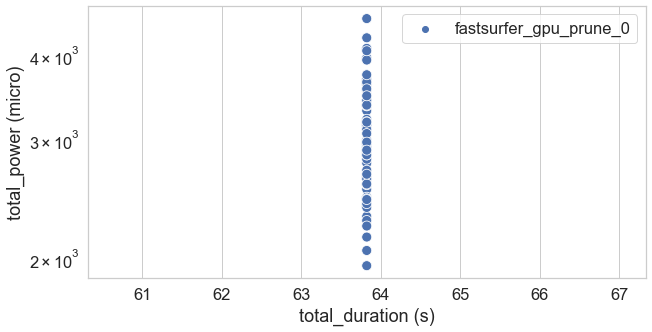

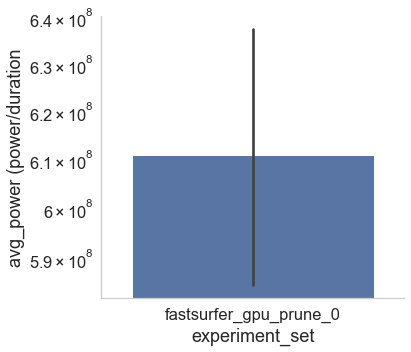

In [56]:
plot_df = tracker_summary_df_concat_exp_set.copy()
plot_df['total_duration (s)'] = plot_df['total_duration'] * 3600
plot_df['total_power (micro)'] = plot_df['total_power'] * (10**6)
plot_df['avg_power (power/duration'] = plot_df['total_power'] * (10**6) / plot_df['total_duration'] * 3600


sns.set(font_scale = 1.5)

# with sns.axes_style("whitegrid"):
    # g = sns.catplot(y='total_power', x='experiment_set', data=plot_df, kind='bar',aspect=3)
    

with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(figsize=(10,5),sharex=False,sharey=False)
    g = sns.scatterplot(y='total_power (micro)', x='total_duration (s)', hue='experiment_set', s=100, data=plot_df)
    g.set(yscale='log') 
    g.legend(loc=0)
    
with sns.axes_style("whitegrid"):
    g = sns.catplot(y='avg_power (power/duration', x='experiment_set', kind='bar', data=plot_df)
    g.set(yscale='log') 

### Power for segmentation

In [ ]:
recon_df = flops_df_concat_exp_set[flops_df_concat_exp_set['task'].isin(['autorecon1','autorecon2'])].copy()
fastsurfer_df = flops_df_concat_exp_set[flops_df_concat_exp_set['experiment_set'].isin(['fastsurfer_gpu_prune_0'])].copy()
print('Before grouping: number of rows for recon task subset: {}, fastsurfer subset: {}'.format(len(recon_df),len(fastsurfer_df)))

recon_df = recon_df.groupby(['experiment_name']).sum().reset_index()
recon_df['experiment_set'] = 'recon-all'

fastsurfer_df = fastsurfer_df.groupby(['experiment_name']).sum().reset_index()
fastsurfer_df['experiment_set'] = 'fastsurfer_gpu_prune_0'
print('After grouping: number of rows for recon task subset: {}, fastsurfer subset: {}'.format(len(recon_df),len(fastsurfer_df)))


plot_df = recon_df.append(fastsurfer_df)
plot_df['segmentation_task_power_draw'] = plot_df['epoch_power_draw']

sns.set(font_scale = 1.5)

with sns.axes_style("whitegrid"):
    g = sns.catplot(y='segmentation_task_power_draw', x='experiment_set', data=plot_df, kind='bar',aspect=3)


### avg power reading

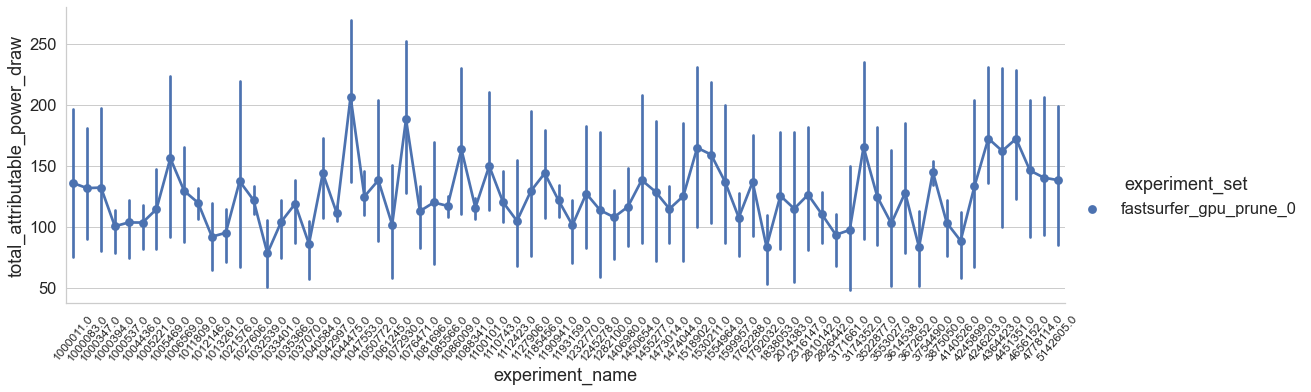

In [57]:
plot_df = power_df_concat_exp_set.copy()

sns.set(font_scale = 1.5)

with sns.axes_style("whitegrid"):
    g = sns.catplot(y='total_attributable_power_draw', x='experiment_name', hue='experiment_set', data=plot_df, kind='point',aspect=3)
    g.set_xticklabels(rotation=50,fontsize=12)


### Flops vs Power

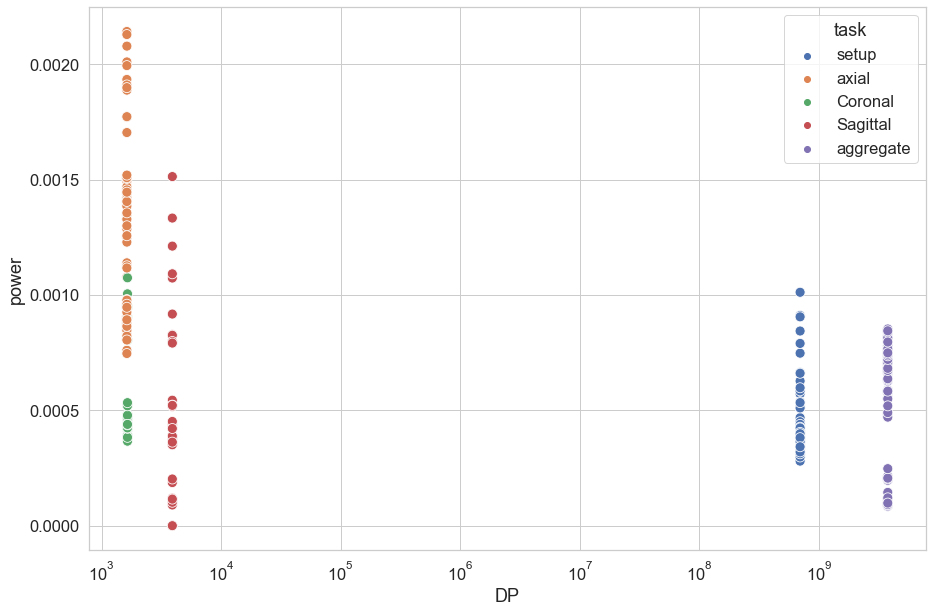

In [58]:
plot_df = flops_df_concat_exp_set.copy()

sns.set(font_scale = 1.5)

with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(figsize=(15,10),sharex=False,sharey=False)
    g = sns.scatterplot(y='power', x='DP', hue='task', s=100, data=plot_df)
    g.set(xscale='log') 


### Issue: nvidia measured samples don't add up to reported experiment total power usage from the tracker

In [ ]:
experiment_set = 'fastsurfer_gpu_prune_0'
avg_total_power_reported = tracker_summary_df_concat_exp_set[(tracker_summary_df_concat_exp_set['experiment_set']==experiment_set)]['total_power'].mean() * (10**6)

avg_total_power_samples = fastsurfer_df['epoch_power_draw'].mean()

print('reported total power: {:4.3f}, sum of measured samples: {:4.3f}'.format(avg_total_power_reported, avg_total_power_samples))

### Power trace

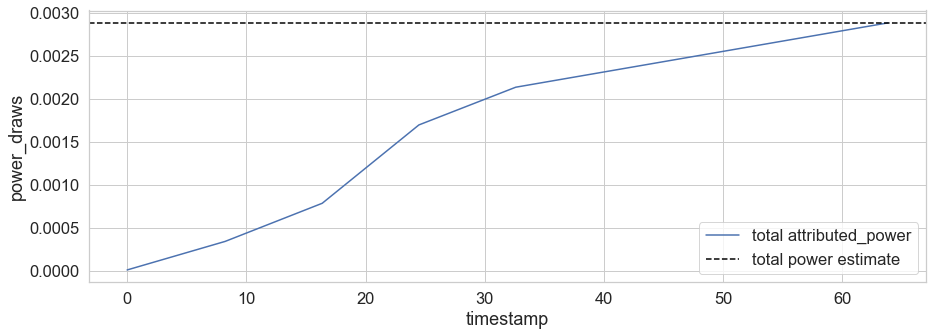

In [59]:
experiment_set =  'fastsurfer_gpu_prune_0' #'recon-all' #'fastsurfer_gpu_prune_0'
experiment_name = 1474044
use_cuda = True
plot_epochs = False

plot_df = power_df_concat_exp_set[(power_df_concat_exp_set['experiment_set']==experiment_set) & (power_df_concat_exp_set['experiment_name']==experiment_name)].copy()
total_power = tracker_summary_df_concat_exp_set[(tracker_summary_df_concat_exp_set['experiment_set']==experiment_set) & (tracker_summary_df_concat_exp_set['experiment_name']==experiment_name)]['total_power'].values[0]
PUE = tracker_summary_df_concat_exp_set[(tracker_summary_df_concat_exp_set['experiment_set']==experiment_set) & (tracker_summary_df_concat_exp_set['experiment_name']==experiment_name)]['PUE'].values[0]

sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(figsize=(15,5),sharex=False,sharey=False)

    g = sns.lineplot(plot_df['timestamp'],plot_df['total_power_per_timestep'].cumsum(),label='total attributed_power')

    if plot_epochs: 
        for e in epochs:
            g = plt.axvline(e, linestyle='-',c='purple')
        
    g = plt.axhline(total_power, linestyle='--',c='black',label='total power estimate')
    
    plt.ylabel('power_draws')
    plt.legend()


In [ ]:
# experiment tracker
sys.path.append('../../')
sys.path.append('../')
sys.path.append('../../experiment-impact-tracker/')

from experiment_impact_tracker.compute_tracker import ImpactTracker
import tempfile
import time

def func1():
    count = 0
    for i in range(100):
        count += i
    return count

def func2():
    count = 0
    for i in range(100):
        count += i**2
    return count

In [ ]:
experiment1 = tempfile.mkdtemp()
experiment2 = tempfile.mkdtemp()

print('Tracker 1')
tracker1  = ImpactTracker(experiment1)
print(tracker1.launched)
with tracker1:
    func1()
    print(tracker1.launched)

time.sleep(1)
print('Tracker 2')
tracker2  = ImpactTracker(experiment2)
print(tracker2.launched)
with tracker2:
    print('Starting context')
    print(tracker2.launched)
    print('Starting func2')
    func2()
    print(tracker2.launched)

In [ ]:
from experiment_impact_tracker.emissions.get_region_metrics import \
    get_current_region_info_cached, get_current_location

In [ ]:
region_info = get_current_region_info_cached()
region_info

In [ ]:
region_info[0]['geometry']

In [ ]:
get_current_location()